# 03_regression_analysis.ipynb

전처리 결과(Parquet)를 로드해 앱 사용량(카테고리)과 수면지표의 주효과 및 조절효과(상호작용) 를 단계적 회귀로 검증합니다. 반복측정(week within uid)을 고려해 cluster-robust 표준오차(그룹=uid) 를 사용합니다. 결과표/VIF/조절효과 그래프를 results/에 저장합니다. (데이터 비공개)

셀 1 — 로드/컬럼 정리

In [11]:
# TL;DR: Parquet 로드 → 중심화/상호작용(여기서만) → OLS(클러스터 SE) → VIF/플롯 저장
import pyarrow.parquet as pq
import pandas as pd, numpy as np
from pathlib import Path

Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/tables").mkdir(parents=True, exist_ok=True)

PARQUET_IN = "results/tables/processed_weekly.parquet"
df = pq.read_table(PARQUET_IN).to_pandas()
df.columns = [c.replace('.', '_') for c in df.columns]


셀 2 — 중심화/상호작용

In [12]:
apps = ['AppCategory_GAME','AppCategory_MAPS','AppCategory_NEWS',
        'AppCategory_PRODUCTIVITY','AppCategory_SOCIAL','AppCategory_VIDEO']

# *_hours 존재 시 그걸 사용
apps = [c if c in df.columns else f"{c}_hours" for c in apps]
y_vars = ['PHQ9_score','GAD7_score','Stress_score']

# 중심화
for c in apps:
    df[f"{c}_c"] = df[c] - df[c].mean()
df["sleep_c"] = df["mean_confidence_sleep"] - df["mean_confidence_sleep"].mean()

# 상호작용
for c in apps:
    short = c.replace("AppCategory_","").replace("_hours","")
    df[f"{short}_x_sleep"] = df[f"{c}_c"] * df["sleep_c"]

# cluster SE를 위한 그룹
df["uid"] = df["uid"].astype("category")


셀 3 — 단계적 회귀(클러스터-강건 SE)

In [13]:
import statsmodels.formula.api as smf

def fit_steps(dep, app):
    """Step1: app_c / Step2: + sleep_c / Step3: + interaction"""
    short = app.replace("AppCategory_","").replace("_hours","")
    f1 = f"{dep} ~ {app}_c"
    f2 = f"{dep} ~ {app}_c + sleep_c"
    f3 = f"{dep} ~ {app}_c + sleep_c + {short}_x_sleep"
    kw = dict(cov_type="cluster", cov_kwds={"groups": df["uid"]})
    return (smf.ols(f1, data=df).fit(**kw),
            smf.ols(f2, data=df).fit(**kw),
            smf.ols(f3, data=df).fit(**kw))

results = {}
for app in apps:
    results[app] = {dep: fit_steps(dep, app) for dep in y_vars}

# Step3 요약 표 저장
rows=[]
for app in apps:
    short = app.replace("AppCategory_","").replace("_hours","")
    for dep in y_vars:
        m = results[app][dep][2]
        rows.append({
            "Category": short, "Dependent": dep, "R2": m.rsquared,
            "App_t": m.tvalues.get(f"{app}_c", np.nan),
            "App_p": m.pvalues.get(f"{app}_c", np.nan),
            "Sleep_t": m.tvalues.get("sleep_c", np.nan),
            "Sleep_p": m.pvalues.get("sleep_c", np.nan),
            "Inter_t": m.tvalues.get(f"{short}_x_sleep", np.nan),
            "Inter_p": m.pvalues.get(f"{short}_x_sleep", np.nan),
        })
summary_df = pd.DataFrame(rows)
summary_df.to_csv("results/tables/moderation_step3_APA.csv", index=False)
summary_df.head()


,Category,Dependent,R2,App_t,App_p,Sleep_t,Sleep_p,Inter_t,Inter_p
0,GAME,PHQ9_score,0.004202,-0.062035,0.950535,-1.840474,0.065699,-2.254974,0.024135
1,GAME,GAD7_score,0.004533,0.560562,0.575096,-1.277687,0.201360,-0.937440,0.348532
2,GAME,Stress_score,0.014888,0.694178,0.487571,-2.581887,0.009826,-2.320983,0.020288
3,MAPS,PHQ9_score,0.004414,-1.167339,0.243073,-1.803867,0.071252,-0.434933,0.663611
4,MAPS,GAD7_score,0.003048,-0.251246,0.801624,-1.161445,0.245461,-0.280719,0.778926


셀 4 — VIF(상호작용 포함)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_rows=[]
for app in apps:
    short = app.replace("AppCategory_","").replace("_hours","")
    vars_v = [f"{app}_c","sleep_c",f"{short}_x_sleep"]
    X = df[vars_v].values
    for i,var in enumerate(vars_v):
        vif_rows.append({"Category":short,"Variable":var,"VIF":vif(X,i)})

vif_df = pd.DataFrame(vif_rows)
vif_df.to_csv("results/tables/vif_by_category.csv", index=False)
vif_df.head()


/home/biot/github/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Category,Variable,VIF
0,GAME,AppCategory_GAME_c,1.002273
1,GAME,sleep_c,1.025005
2,GAME,GAME_x_sleep,1.025498
3,MAPS,AppCategory_MAPS_c,1.026851
4,MAPS,sleep_c,1.011630


셀 5 — 조절효과 플롯(유의한 것만 저장)

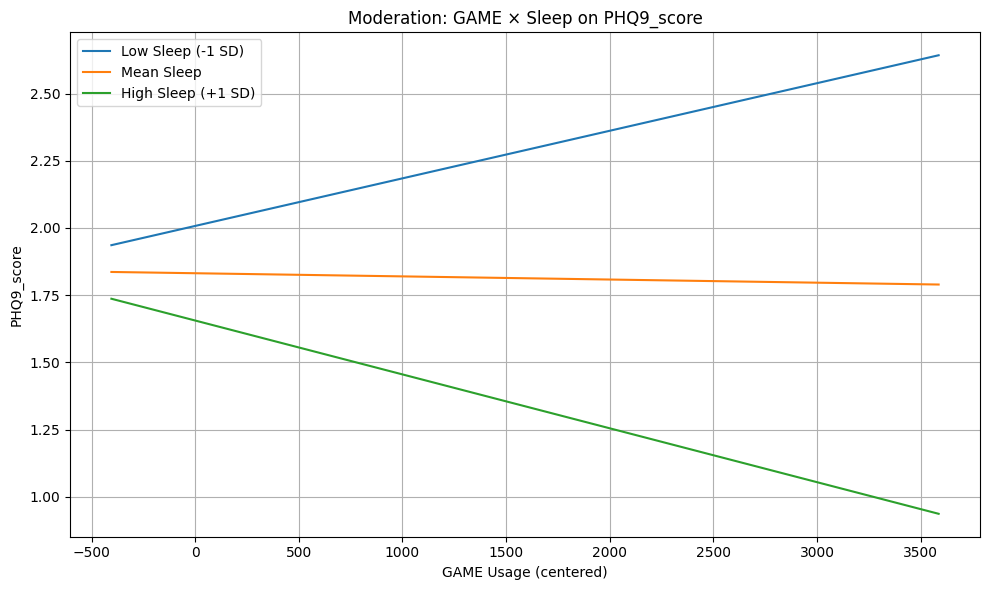

→ 저장: results/figures/moderation_GAME_PHQ9_score.png


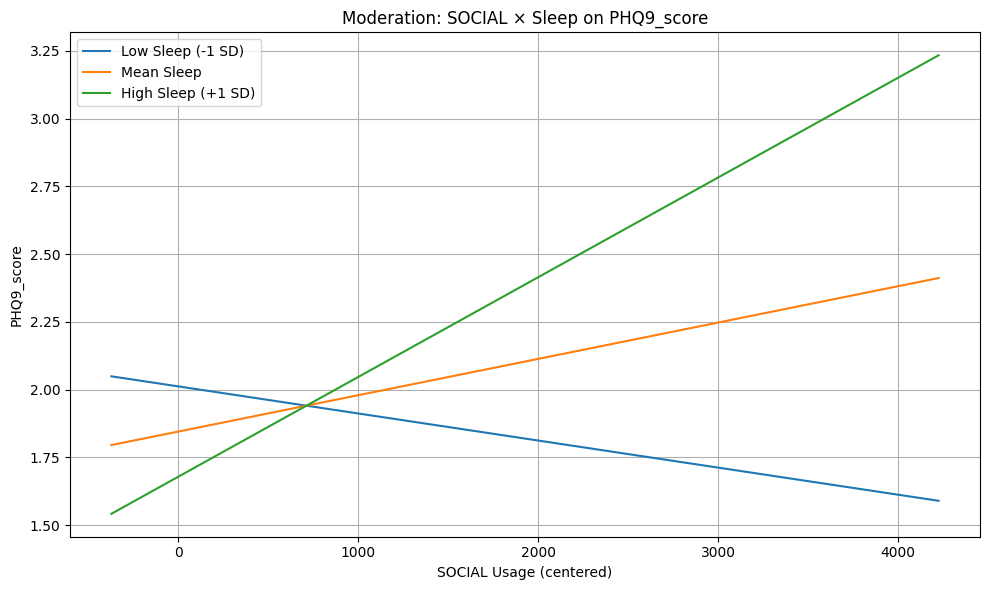

→ 저장: results/figures/moderation_SOCIAL_PHQ9_score.png


In [15]:
import matplotlib.pyplot as plt

def plot_moderation(dep, model, app_short, app_c_col):
    x = np.linspace(df[app_c_col].min(), df[app_c_col].max(), 200)
    mean, std = df["sleep_c"].mean(), df["sleep_c"].std()
    inter = f"{app_short}_x_sleep"

    b0 = model.params.get("Intercept",0)
    b1 = model.params.get(app_c_col,0)
    b2 = model.params.get("sleep_c",0)
    b3 = model.params.get(inter,0)

    y_low  = b0 + b1*x + b2*(mean-std) + b3*x*(mean-std)
    y_mid  = b0 + b1*x + b2* mean      + b3*x* mean
    y_high = b0 + b1*x + b2*(mean+std) + b3*x*(mean+std)

    plt.figure(figsize=(10,6))
    plt.plot(x,y_low, label='Low Sleep (-1 SD)')
    plt.plot(x,y_mid, label='Mean Sleep')
    plt.plot(x,y_high,label='High Sleep (+1 SD)')
    plt.xlabel(f'{app_short} Usage (centered)'); plt.ylabel(dep)
    plt.title(f'Moderation: {app_short} × Sleep on {dep}')
    plt.legend(); plt.grid(True)
    out = f"results/figures/moderation_{app_short}_{dep}.png"
    plt.tight_layout(); plt.savefig(out, dpi=180); plt.show()
    print("→ 저장:", out)

# 예: PHQ9만 도식 (원하시면 GAD7/Stress도 반복)
for app in apps:
    short = app.replace("AppCategory_","").replace("_hours","")
    m = results[app]["PHQ9_score"][2]
    if m.pvalues.get(f"{short}_x_sleep", 1.0) < 0.05:
        plot_moderation("PHQ9_score", m, short, f"{app}_c")
